<a href="https://colab.research.google.com/github/vhoma/ydata-viz-ai/blob/main/NN_sharing_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install packages

In [1]:

!pip install wget
!pip install -U git+https://github.com/pydicom/pydicom.git
#pip install --no-cache-dir git+https://github.com/pydicom/pydicom.git
!pip install python-gdcm

!pip install torchsummary 



  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=53fa564db846f1670fd14befc0ac6f8a3d374925fedf4b5709bc025f7f599718
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Cloning https://github.com/pydicom/pydicom.git to /tmp/pip-req-build-c25zh_og
  Running command git clone -q https://github.com/pydicom/pydicom.git /tmp/pip-req-build-c25zh_og
  Created wheel for pydicom: filename=pydicom-2.4.0.dev0-py3-none-any.whl size=1966307 sha256=373bc5637be78140ebd0adfbdc4dc23557ad4cf92c7794571075d5fd58c30070
  Stored in directory: /tmp/pip-ephem-wheel-cache-et8y_19h/wheels/8a/75/6f/a3a81ff6d9eaa04f50d99238b899485b32c5948527a33b243c
Successfully built pydicom
     |████████████████████████████████| 12.6 MB 7.0 MB/s 


In [2]:
import dicom_utils as dcm
import Affine3D as affine
from scipy.ndimage import affine_transform

In [ ]:
#input_file = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/YdataDataset.txt" 
#data_path = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/data03_01"

In [ ]:
#to work from Colab and google disk:
from google.colab import drive 
from pathlib import Path
import os

drive.mount('/content/drive')

home_path = Path("/content/drive/MyDrive/VIZ/data/data03_01")

#data_path = os.path.join(home_path, "data")
#print(data_path)

In [5]:
# (OPTIONAL) can run this to copy from drive and unzip

from zipfile import ZipFile, BadZipFile

# copy from drive to local storage
!cp /content/drive/MyDrive/YDATA/viz-ai/data100.zip ./

# unzip
archive_path = "./data100.zip"
with ZipFile(archive_path, 'r') as zip_obj:
    zip_obj.extractall("./data/")

# set main data dir
home_path = "./data"

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import copy

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid

#Model

In [12]:
x = torch.rand(1,3,64,64) # input x
y = torch.rand(1,3,64,64) # input y
cnn = nn.Conv2d(3,10,kernel_size=5) # network
input = torch.cat((x,y),dim=0) # stack them batch-wise
output = cnn(input) # pass both x and y through the network as a single pass
x_out = output[0] # get the output of x
y_out = output[1] # get the output of y

### Variant 1 (concatenating the input)

In [ ]:
class Our_AirNet(nn.Module):
    def __init__(self):
        super(Our_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))    
        
    def forward(self, x, y):
        inp = torch.cat((x,y),dim=0) # stack them batch-wise
        inp = self.firstlayer(inp)
        inp = self.transition(inp) #80
        inp = self.transition(inp) #40
        inp = self.transition(inp) #20
        input_conc = torch.cat((inp[:inp.shape[0]].flatten(),inp[inp.shape[0]:].flatten()),dim=0)
        #inp = self.flatten(inp)
        res = self.regression(input_conc)
        return res        



In [ ]:
model = Our_AirNet()
summary(model, (20, 320, 320), batch_size=1)

TypeError: ignored

In [ ]:

a = torch.rand(1,3,5,5) # input a
print(a.shape)
b = torch.rand(1,3,5,5) # input b
print(b.shape)
c = torch.cat((a,b),dim=0) # stack them batch-wise
n=a.shape[0]
c.shape

d = torch.cat((c[:a.shape[0]].flatten(),c[a.shape[0]:].flatten()),dim=0)
d.shape
#print(input_conc)
c[:a.shape[0]].shape

a = a.flatten()
a.shape
b = b.flatten()
c.shape
c = torch.cat((a,b), dim=0)


torch.Size([150])

In [13]:
def normalize(img, min_val, max_val):
    return (img - min_val) / (max_val - min_val)

def transform(img):
    alpha = np.random.randint(-45, 45)
    m = affine.Affine3dRotateCenterMatrix(alpha, img.shape, axis=2)
    return affine.affine_transform(img, m), m

class Img3dDataSet(Dataset):
    def __init__(self, data_path, min_val, max_val):
        self.d_path = data_path
        self.min_val = min_val
        self.max_val = max_val
        self.transform = None
        self.target_transform = None
        names = [f for f in os.listdir(data_path) if f.endswith(".npz")]
        self.names_array = np.sort(np.array(names))
        
    def __getitem__(self, idx):
        name = self.names_array[idx]
        img3d = np.load(os.path.join(self.d_path, name))['I']
        img3d = normalize(img3d, self.min_val, self.max_val)
        label, matrix = transform(img3d)
        print(label.shape, matrix.shape)
        matrix = matrix[:3,:]
        print(matrix)
        label = label.transpose(2, 0, 1)
        label = torch.from_numpy(label).float()
        #adding this to get the dimensions nedded
        img3d = img3d.transpose(2, 0, 1)
        #print(img3d.shape , label.shape)
        item = torch.from_numpy(img3d).float()
        return item, label, matrix
    
    def __len__(self):
        return len(self.names_array)

In [118]:
def normalize(img, min_val, max_val):
    return (img - min_val) / (max_val - min_val)


def transform(img):
    alpha = np.random.randint(-45, 45)
    m = affine.Affine3dRotateCenterMatrix(alpha, img.shape, axis=2)
    return affine_transform(img, m), m, alpha


class Img3dDataSet(Dataset):
    def __init__(self, data_path, min_val, max_val):
        self.d_path = data_path
        self.min_val = min_val
        self.max_val = max_val
        self.transform = None
        self.target_transform = None
        names = [f for f in os.listdir(data_path) if f.endswith(".npz")]
        self.names_array = np.sort(np.array(names))

    def __getitem__(self, idx):
        name = self.names_array[idx]
        img3d = np.load(os.path.join(self.d_path, name))['I']
        img3d = normalize(img3d, self.min_val, self.max_val)

        # transform original image twice
        t1, m1, alpha1 = transform(img3d)
        t2, m2, alpha2 = transform(img3d)
        print("...transformed with angles: {} {}".format(alpha1, alpha2))

        # find transform matrix from 1st to 2nd
        matrix = affine.Affine3dRotateCenterMatrix(alpha2 - alpha1, img3d.shape, axis=2)

        # transpose images and remove last row from the matrix
        t1 = t1.transpose(2, 0, 1)
        t2 = t2.transpose(2, 0, 1)
        matrix = matrix[:3,:]

        # convert to torch
        return torch.from_numpy(t1).float(), torch.from_numpy(t2).float(), matrix
    
    def __len__(self):
        return len(self.names_array)

In [119]:
dataset = Img3dDataSet(home_path, -1000, 1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [125]:
%%time
x, y, matrix = next(iter(dataloader))

...transformed with angles: 20 -25
CPU times: user 1.6 s, sys: 3.2 ms, total: 1.6 s
Wall time: 1.6 s


In [126]:
x.shape, y.shape, matrix.shape

(torch.Size([1, 20, 320, 320]),
 torch.Size([1, 20, 320, 320]),
 torch.Size([1, 3, 4]))

In [127]:
matrix1 = matrix[:,:3,:]

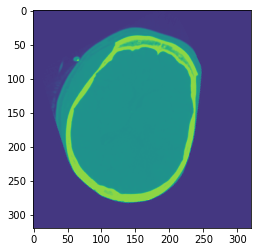

In [128]:
plt.imshow(x[0][10,:,:])

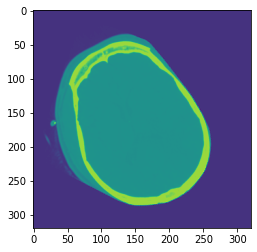

In [129]:
plt.imshow(y[0][10,:,:])

#Running model

In [130]:
model = Our_AirNet()
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 200

NameError: ignored

In [106]:
best_loss = np.inf
loss_history = [] 
best_model_wts = copy.deepcopy(model.state_dict())
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        res = model(x, y)
        #print(res.shape)
        print(res)
        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts = copy.deepcopy(model.state_dict())

        loss_history.append(loss.item())



print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model.load_state_dict(best_model_wts)
#y.shape

NameError: ignored

In [ ]:
#Printing the input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])


print('the output of the model')
model.load_state_dict(best_model_wts)
result_matrix = model(x, y)


tensor([[ 9.8147e-01, -8.1401e-03,  5.1716e-03,  1.1570e+01,  7.4433e-02,
          1.0004e+00, -2.1785e-02, -1.0747e+01, -5.9782e-03, -1.8252e-02,
          1.0093e+00,  2.6488e-02],
        [ 9.7994e-01, -8.4565e-03,  4.6730e-03,  1.1575e+01,  7.3543e-02,
          1.0003e+00, -2.2586e-02, -1.0752e+01, -6.4863e-03, -1.8585e-02,
          1.0096e+00,  2.7398e-02]], grad_fn=<AddmmBackward0>)

###Variant2 (Siamese network)

In [131]:
class Siam_AirNet(nn.Module):
    def __init__(self):
        super(Siam_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))   

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.firstlayer(x)
        output = self.transition(output)
        output = self.transition(output)
        output = self.transition(output)
        output = self.flatten(output)        
        return output

    def forward(self, input_t, input_ref):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        input_t = self.forward_once(input_t)
        #print(input_t.shape)
        input_ref = self.forward_once(input_ref)
        #print(input_ref.shape)
        input_conc = torch.cat((input_t,input_ref),dim=1)
        #print(input_conc.shape)
        res = self.regression(input_conc)
        return res 

In [132]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [133]:
model2 = Siam_AirNet()
model2.train()
model2 = model2.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model2.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 300

tensor([[ 0.0344,  0.0602,  0.0041, -0.0048, -0.1117,  0.0649, -0.1082,  0.0435,
         -0.0475,  0.0682, -0.0445,  0.1308]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 0
 Current loss 29980.458984375

tensor([[ 22.6548,   4.6454,   4.2984,  -9.3092, -17.5542,   7.9679, -10.0153,
          29.8318,  -0.3392, -13.7446,   7.1518,  16.1871]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 1
 Current loss 21630.19921875

tensor([[118.2183,  11.4214,  16.5858, -65.9180, -59.4828,  -8.3663,  -4.9868,
         222.8834,  12.5606, -41.1635,  19.7903,  36.1648]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 2
 Current loss 25228.15234375

tensor([[ 24.9455, -11.1192,   0.8237, -37.2645,  -2.2323,  -1.3187,   6.8672,
          64.1323,  -7.8610,   5.2226,   6.4117,  -0.8413]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 3
 Current loss 10932.865234375

tensor([[  7.4036, -13.8206, -14.0172, -38.3837,   2.9904,   3.4421,  

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 8
 Current loss 1317.447998046875

tensor([[-3.4944e+00,  1.0414e+01,  4.5276e+00, -4.6992e+01, -6.7467e+00,
         -2.5736e+00, -5.9423e+00,  1.5824e+02,  1.1667e+01,  9.4874e-01,
         -9.7127e+00,  1.0753e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch number 9
 Current loss 841.6456909179688

tensor([[  1.2458,  11.5794,  22.1754, -55.8874,  -8.3032, -10.1102, -14.3804,
         190.8320,  13.0029,   4.7473, -10.3051,   1.0210]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 10
 Current loss 2370.71044921875

tensor([[  0.9495,   7.3034,  25.9805, -50.0427,  -1.6506,  -9.5029, -14.2700,
         154.1478,   6.5348,   6.8635,  -3.1294,   1.8236]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 11
 Current loss 1435.2183837890625

tensor([[  2.2635,   3.0359,  23.9767, -49.0124,   0.5683,  -6.9391, -10.2911,
         135.5299,   0.1907,   4.3210,  -0.4936,   1.2467]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch nu

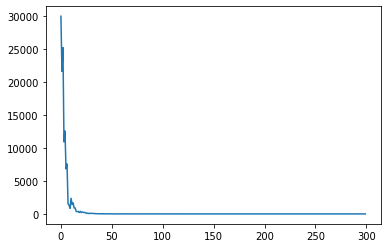

<All keys matched successfully>

In [134]:
best_loss = np.inf
loss_history = [] 
best_model_wts2 = copy.deepcopy(model2.state_dict())
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        matrix_gpu = matrix.to(device)

        # Pass in the two images into the network and obtain two outputs
        res = model2(x_gpu, y_gpu)
        print(res)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix_gpu.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts2 = copy.deepcopy(model2.state_dict())

        loss_history.append(loss.item())
print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model2.load_state_dict(best_model_wts2)


### Model output check

the input


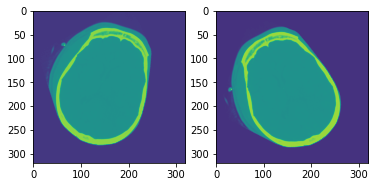

In [135]:
#Printing the input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])




the output of the model
tensor(431144.9062)
431139.5
427015.1


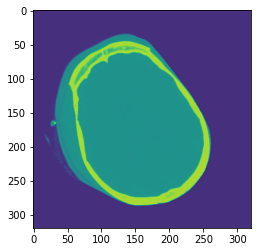

tensor(11.6951, dtype=torch.float64)
11.695112864258265


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [136]:
print('the output of the model')

result_matrix = model2(x_gpu, y_gpu)
result_matrix = result_matrix.cpu().detach().numpy()
print(y.sum())
result_matrix_new = np.append(result_matrix,[0, 0, 0, 1]).reshape(4,4)
result_matrix.shape
x_nmp = x.detach().numpy()[0].transpose(1, 2, 0)
print(x_nmp.sum())
plt.imshow(x_nmp[:,:,10])
x_new = affine_transform(x_nmp, result_matrix_new)
print(x_new.sum())
plt.imshow(x_new[:,:,10])
plt.show()

m_check = np.array([[0.7431448, 0.6691306, 0., -65.964066 ],
 [-0.6691306, 0.7431448, 0., 148.15773],
 [0.,0., 1., 0.]])
m_check = m_check.flatten()


err = np.sum(np.power(np.subtract(m_check, result_matrix),2))/12

#y_nmp.shape

mse = nn.MSELoss()
m_check_tensor = torch.tensor(m_check)
matrix_tensor = torch.tensor(result_matrix)
print(mse(m_check_tensor, matrix_tensor))
print(err)

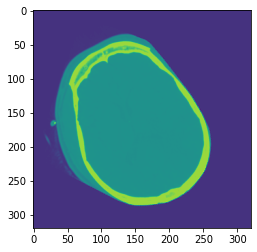

In [137]:
#plt.imshow(y[:,:,10])
y_nmp = y.detach().numpy()[0].transpose(1, 2, 0)
plt.imshow(y_nmp[:,:,10])

In [138]:
matrix

tensor([[[  0.7071,   0.7071,   0.0000, -66.2742],
         [ -0.7071,   0.7071,   0.0000, 160.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000]]])

In [139]:
res.cpu().detach().numpy()

array([[ 7.0709801e-01,  7.0710349e-01,  2.7172267e-05, -6.6274139e+01,
        -7.0711464e-01,  7.0708954e-01, -8.8438392e-06,  1.6000002e+02,
        -3.3900142e-07,  5.9977174e-06,  9.9999070e-01, -2.2657216e-05]],
      dtype=float32)

In [140]:
x_65 = torch.tensor(np.array([  1.0197,   0.2484,  -0.4615, -65.7467,  -0.9316,   0.5529,  -0.8590,
         147.3966,  -0.2259,   0.2153,   1.0492,  -0.2639]))
x_65.shape

torch.Size([12])

In [141]:
mse(m_check_tensor, res.cpu().detach())
mse(m_check_tensor, x_65)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1755, dtype=torch.float64)